In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget


In [8]:
def stepcounter(idx:int,idxmax:list):
    lidx=idx+1
    lst=[]

    for i in range(len(idxmax)):
        lst=[np.mod(lidx,idxmax[-i-1])] + lst
        lidx=lidx//idxmax[-i-1]
    return (idx+1,lst)
    


def read_outfile(linfile_name:str):

    with open(linfile_name) as lfile:
        for lline in lfile:
            if("[INIT ML][0]number of MultiLevels=" in lline):
                nllev = int(re.split("=",lline)[1])
                nit_tune_levels=[None]* nllev
                gbidx=toridx=-1 

            elif("[INIT ML][0]ML tuning level=" in lline):
                tunelev = int(re.split("=",lline)[1]) 
                nit_tune_levels=nit_tune_levels[:(tunelev+1)]
                print(f"Output file contain tuning on lev:{tunelev}")
                print(f"Each conf contains {np.prod(nit_tune_levels)} different measures split along {nit_tune_levels} remaining update levels")

                store=[]
            elif("[INIT ML][0]lev " in lline):
                stringsplit = re.split("=| ",lline)
                llevid=int(stringsplit[2])
                lup=int(stringsplit[4])
                nit_tune_levels[llevid]=lup
            elif("[MAIN][0]Configuration " in lline):
                cnfgid=int(lline.split()[1])
                assert(np.mod(gbidx,np.prod(nit_tune_levels))== np.prod(nit_tune_levels)-1)
                assert(np.mod(toridx,np.prod(nit_tune_levels))== np.prod(nit_tune_levels)-1)
            elif("[Measure ML][0]1pt function P=" in lline or "[Measure ML][0]1ptTor function P=" in lline):
                stringsplit = lline.split()
                if(stringsplit[1]=='ML][0]1pt'):
                    typestring="glueball"
                    (gbidx,idxlst) = stepcounter(gbidx,nit_tune_levels)
                else:   
                    typestring="torellon"
                    (toridx,idxlst) = stepcounter(toridx,nit_tune_levels)
                plst = list(map(lambda x:int(x), re.split("P=\(|,|\)", stringsplit[3] )[1:-1]))
                irrepstring = re.split("=", stringsplit[4] )[1]
                evstring = re.split("=", stringsplit[6] )[1]
                chargestring = re.split("=", stringsplit[7] )[1]
                data_dic={"cfgid":cnfgid,"type":typestring,"momenta": plst ,"irrep":irrepstring,"charge":chargestring,"ev":evstring}
                for i in range(tunelev+1):
                    data_dic["ML_index"+str(i)]=idxlst[i]
            elif("[Measure ML][0] t=" in lline):
                stringsplit = re.split("=|\(|\)| ",lline)[3:]
                data_dic["t"]=int(stringsplit[0])
                data_dic["values"]=[float(i) for i in stringsplit[1:-1] if i ]
                store.append(data_dic.copy())
    if(toridx!=-1):
        print(f"Found {(toridx+1)//np.prod(nit_tune_levels)} torellons configuration measurements")
    if(gbidx!=-1):
        print(f"Found {(gbidx+1)//np.prod(nit_tune_levels)} glueballs configuration measurements")
    data_df = pd.DataFrame(store)
    #data_df.astype)
 
    return data_df
 
def data_select(dataf,type,irrep,charge,ev):
    data_df2=dataf[ ( dataf["type"]=="glueball" ) & ( dataf["irrep"]=="A1plusOhP" ) & ( dataf["charge"]=="+" ) & ( dataf["ev"]=="1/1" ) ]
    assert(data_df2.size>0)
    print(f'Available t indices {data_df2["t"].unique()}')
    nop=data_df2['values'].apply(lambda x: len(x)).unique()
    assert(len(nop)==1)
    print(f'Number of available operators {nop[0]}')
    return data_df2
            
def tune_meas(dataf,tid:int,opid:int,ncut:int):
    data_df3=dataf[dataf["t"]==tid].copy()
    tunename = [ i for i in data_df3.columns if re.search("^ML_index",i)][-1]
    resttunename =["cfgid"] + [ i for i in data_df3.columns if re.search("^ML_index",i)][:-1]
    data_df3['values']=data_df3['values'].apply(lambda x: x[0])
    mean = data_df3['values'].mean()
    data_df3['values']=data_df3['values'].apply(lambda x: x-mean)
    data_df4=data_df3.groupby(resttunename).agg({'values':['mean']},axis=0).reset_index()['values']['mean']
    stddev = data_df4.std()/np.sqrt(len(data_df4)-1)

    check_elem=data_df3[data_df3[tunename]<ncut].groupby(resttunename, group_keys=True)["cfgid"].count().values
    assert(len(set(check_elem)) == 1)
    true_cut=check_elem[0]
    data_df4=data_df3[data_df3[tunename]<true_cut]
    data_df5 = data_df4[resttunename+ ["values"]].groupby(resttunename, group_keys=True).agg({'values':['mean','std']},axis=0).reset_index(col_level=1)["values"]
    data_df5["std"] = data_df5["std"] / np.sqrt(true_cut-1)
    return [stddev,data_df5.values.tolist()]

def stdmean(ar):
    return np.std(ar)/np.sqrt(len(ar)-1)

def tune_meas(dataf,tid:int,opid:int,ncut:int):
    data_df3=dataf[dataf["t"]==tid].copy()
    data_df3.drop(columns=['stdmean'], inplace=True, errors='ignore')
    tunename = [ i for i in data_df3.columns if re.search("^ML_index",i)][-1]
    resttunename =["cfgid","t"] + [ i for i in data_df3.columns if re.search("^ML_index",i)][:-1]
    if(type(data_df3["values"].iloc[0])==list):
        data_df3['values']=data_df3['values'].apply(lambda x: x[0])
        mean = data_df3['values'].mean()
        data_df3['values']=data_df3['values'].apply(lambda x: x-mean)
        data_df4=data_df3.groupby(resttunename).agg({'values':['mean']},axis=0).reset_index()['values']['mean']
        stddev = data_df4.std()/np.sqrt(len(data_df4)-1)
    check_elem=data_df3[data_df3[tunename]<ncut].groupby(resttunename, group_keys=True)["cfgid"].count().values
    assert(len(set(check_elem)) == 1)
    true_cut=check_elem[0]
    data_df4=data_df3[data_df3[tunename]<true_cut]
    data_df5 = data_df4[resttunename+ ["values"]].groupby(resttunename, group_keys=True).agg(['mean',stdmean],axis=0).reset_index().droplevel(0,axis=1).copy()
    data_df5.columns = resttunename + ["values","stdmean"]
    if(true_cut!=ncut):
        print(f"Maximal cut level used {true_cut}")
    return [stddev,data_df5]


In [9]:
data_df1=read_outfile("./out_0_good")

Output file contain tuning on lev:1
Each conf contains 10000 different measures split along [100, 100] remaining update levels
Found 7 torellons configuration measurements
Found 7 glueballs configuration measurements


In [10]:
data_df1_2 = data_df1[data_df1["cfgid"]!=0].copy()
data_df2=data_select(data_df1_2 , "glueball" , "A1plusOhP" , "+" ,"1/1" )

Available t indices [5 6 8 9]
Number of available operators 8


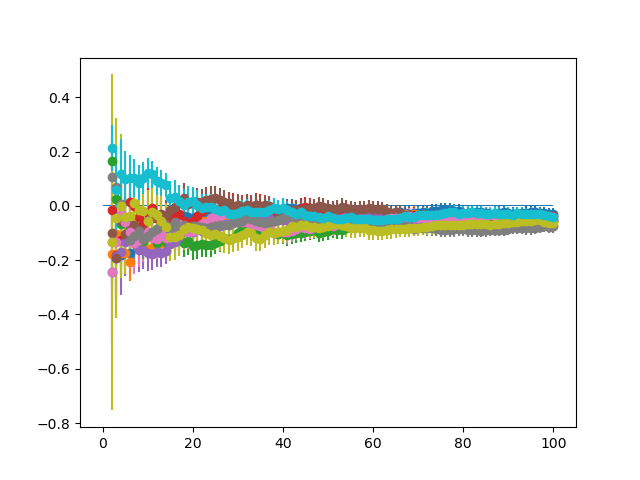

In [13]:
x1=y1=e1=[]
for cut in range(2,101):
    [std,mat] = tune_meas(data_df2,9,0,cut)
    [ly1,le1] = [mat["values"].tolist(),mat["stdmean"].tolist()]
    lx1= [cut]*len(ly1)
    x1=x1+[lx1]
    y1=y1+[ly1]
    e1=e1+[le1]


x1 = np.array(x1).T
y1 = np.array(y1).T
e1 = np.array(e1).T
fig, ax = plt.subplots()


for i in range(10,20):
    ax.errorbar(x1[i], y1[i], yerr=e1[i], fmt="o")    
ax.fill_between([0,100],[std,std],[-std,-std])
plt.show()


In [ ]:
y1l=e1l=x1l=[]
for j in range(0,6):
    y1l=y1l+[[np.array(y1[j*100:i+j*100]).mean() for i in range(1,100)]]
    e1l=e1l+[[np.array(y1[j*100:i+j*100]).std()/np.sqrt(i) for i in range(1,100)]]
    x1l=x1l+[[i for i in range(1,100)]]


In [ ]:
len(e1l[0])

In [ ]:
plt.errorbar(x1l[i], y1l[i], yerr=e1l[i], fmt="o")    


In [ ]:

fig, ax = plt.subplots()
for i in range(0,6):
    ax.errorbar(x1l[i], y1l[i], yerr=e1l[i], fmt="o")    
ax.fill_between([10,100],[std,std],[-std,-std])
plt.show()

In [ ]:
np.sum([y1l[i][10] for i in range(6)])

In [ ]:
def stdmean(ar):
    return np.std(ar)/np.sqrt(len(ar)-1)

def tune_meas(dataf,tid:int,opid:int,ncut:int):
    data_df3=dataf[dataf["t"]==tid].copy()
    data_df3.drop(columns=['stdmean'], inplace=True, errors='ignore')
    tunename = [ i for i in data_df3.columns if re.search("^ML_index",i)][-1]
    resttunename =["cfgid","t"] + [ i for i in data_df3.columns if re.search("^ML_index",i)][:-1]
    if(type(data_df3["values"].iloc[0])==list):
        data_df3['values']=data_df3['values'].apply(lambda x: x[0])
    mean = data_df3['values'].mean()
    data_df3['values']=data_df3['values'].apply(lambda x: x-mean)
    data_df4=data_df3.groupby(resttunename).agg({'values':['mean']},axis=0).reset_index()['values']['mean']
    stddev = data_df4.std()/np.sqrt(len(data_df4)-1)
    check_elem=data_df3[data_df3[tunename]<ncut].groupby(resttunename, group_keys=True)["cfgid"].count().values
    assert(len(set(check_elem)) == 1)
    true_cut=check_elem[0]
    data_df4=data_df3[data_df3[tunename]<true_cut]
    data_df5 = data_df4[resttunename+ ["values"]].groupby(resttunename, group_keys=True).agg(['mean',stdmean],axis=0).reset_index().droplevel(0,axis=1).copy()
    data_df5.columns = resttunename + ["values","stdmean"]
    return data_df5

In [ ]:
data_df3=tune_meas(data_df2,9,0,100)
data_df3

,cfgid,t,ML_index0,values,stdmean
0,1,9,0,-0.164404,0.025197
1,1,9,1,0.021360,0.022788
2,1,9,2,-0.022708,0.018899
3,1,9,3,-0.034514,0.021589
4,1,9,4,-0.075373,0.018317
...,...,...,...,...,...
595,6,9,95,0.039081,0.024434
596,6,9,96,0.028860,0.022200
597,6,9,97,0.036375,0.026149
598,6,9,98,0.069018,0.023217


In [ ]:
tune_meas(data_df3,9,0,100)

,cfgid,t,values,stdmean
0,1,9,-0.058856,0.003134
1,2,9,-0.049051,0.003045
2,3,9,0.003396,0.003599
3,4,9,0.030972,0.002753
4,5,9,0.024453,0.002798
5,6,9,0.049086,0.002686


In [ ]:
tune_meas(data_df2,9,0,50).values.reshape(6, 100,2)


In [ ]:
tune_meas(data_df2,9,0,50)